In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/m1m2_cut`


h_plot (generic function with 1 method)

In [2]:
## Output Directory for Plots
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 20
yticklabelsize = 20
titlesize = 35

plot_save = true

35

# Load Traces

In [4]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.25, minimum Neff_sel = 1801.0, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:4


In [6]:
trace_samples_0p1 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.1.nc"))
ne_min = dropdims(minimum(trace_samples_0p1.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p1.posterior.Neff_sel)
@info "p_cut = 0.1, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p1.posterior, :event)))"

┌ Info: p_cut = 0.1, minimum Neff_samps: 4.19, minimum Neff_sel = 1277.8, 4*Nobs = 220
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sdnNjb2RlLXJlbW90ZQ==.jl:4


In [9]:
trace_samples_0p9 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p9.posterior.Neff_sel)
@info "p_cut = 0.9, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p9.posterior, :event)))"

┌ Info: p_cut = 0.9, minimum Neff_samps: 4.25, minimum Neff_sel = 894.4, 4*Nobs = 176
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sdnNjb2RlLXJlbW90ZQ==.jl:4


## Compare Marginal $m_1$ with $p_{\mathrm{cut}}$

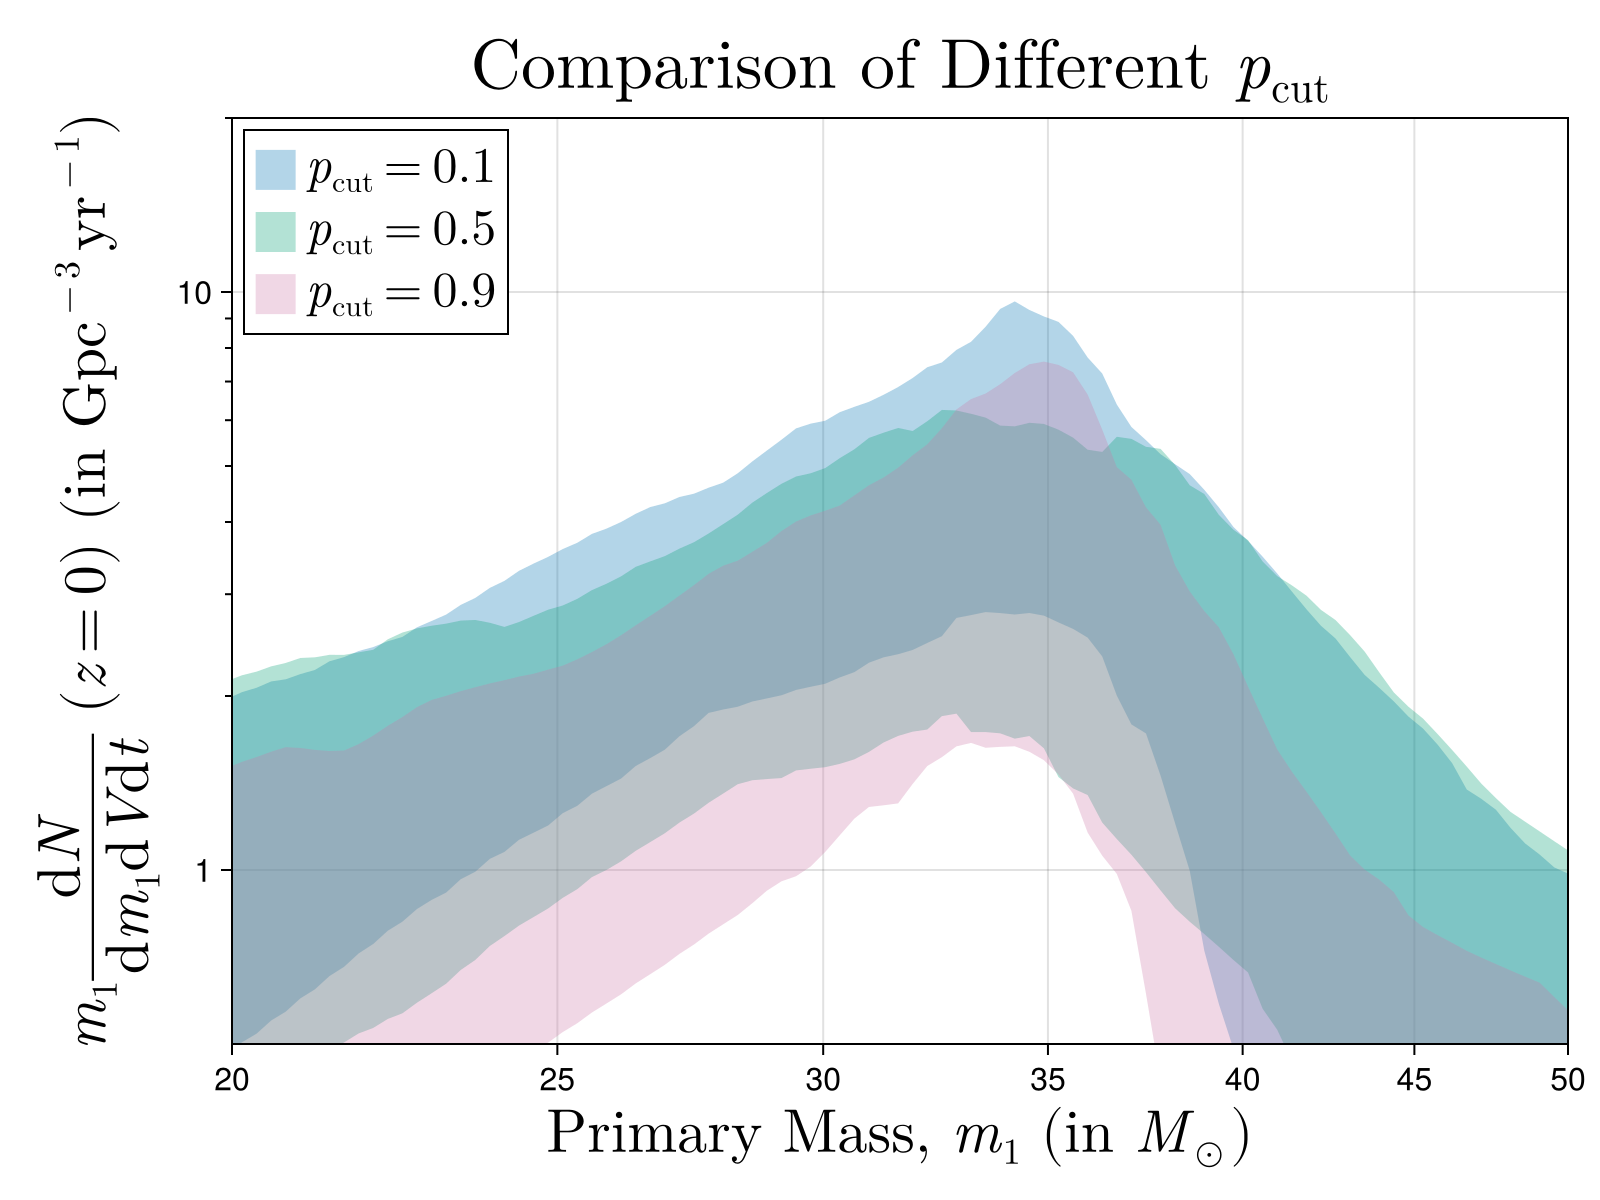

In [25]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max))
qs=0.001:0.01:1
draws=100
rng=Random.default_rng()
colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green


f = Figure(size=(800, 600))
a = Axis(f[1,1],
    xlabel = L"\mathrm{Primary~Mass},~m_1~(\mathrm{in~}M_\odot)",
    ylabel = L"m_1 \frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} V \mathrm{d} t}~(z=0)~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    xscale = log10, yscale = log10,
    xticks = [20, 25, 30, 35, 40, 45, 50], xtickformat = "{:.0f}",
    yticks = [1, 10, 100], yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], yminorticksvisible = true, ytickformat = "{:.0f}",
    xlabelsize = xlabelsize,
    ylabelsize = ylabelsize,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    titlesize = titlesize,
    title=L"\mathrm{Comparison~of~Different}~p_{\mathrm{cut}}",
    limits = (20.0, 50.0, 0.5, 20.0)
)

# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")

axislegend(a, position = :lt, labelsize = 25, framevisible = true)  # top-right inside the plot
if plot_save
    save(outdir * "appen_pcut_m1_marginal.pdf", f, px_per_unit=3)
end
f

## Compare Marginal $q$ with $p_{\mathrm{cut}}$

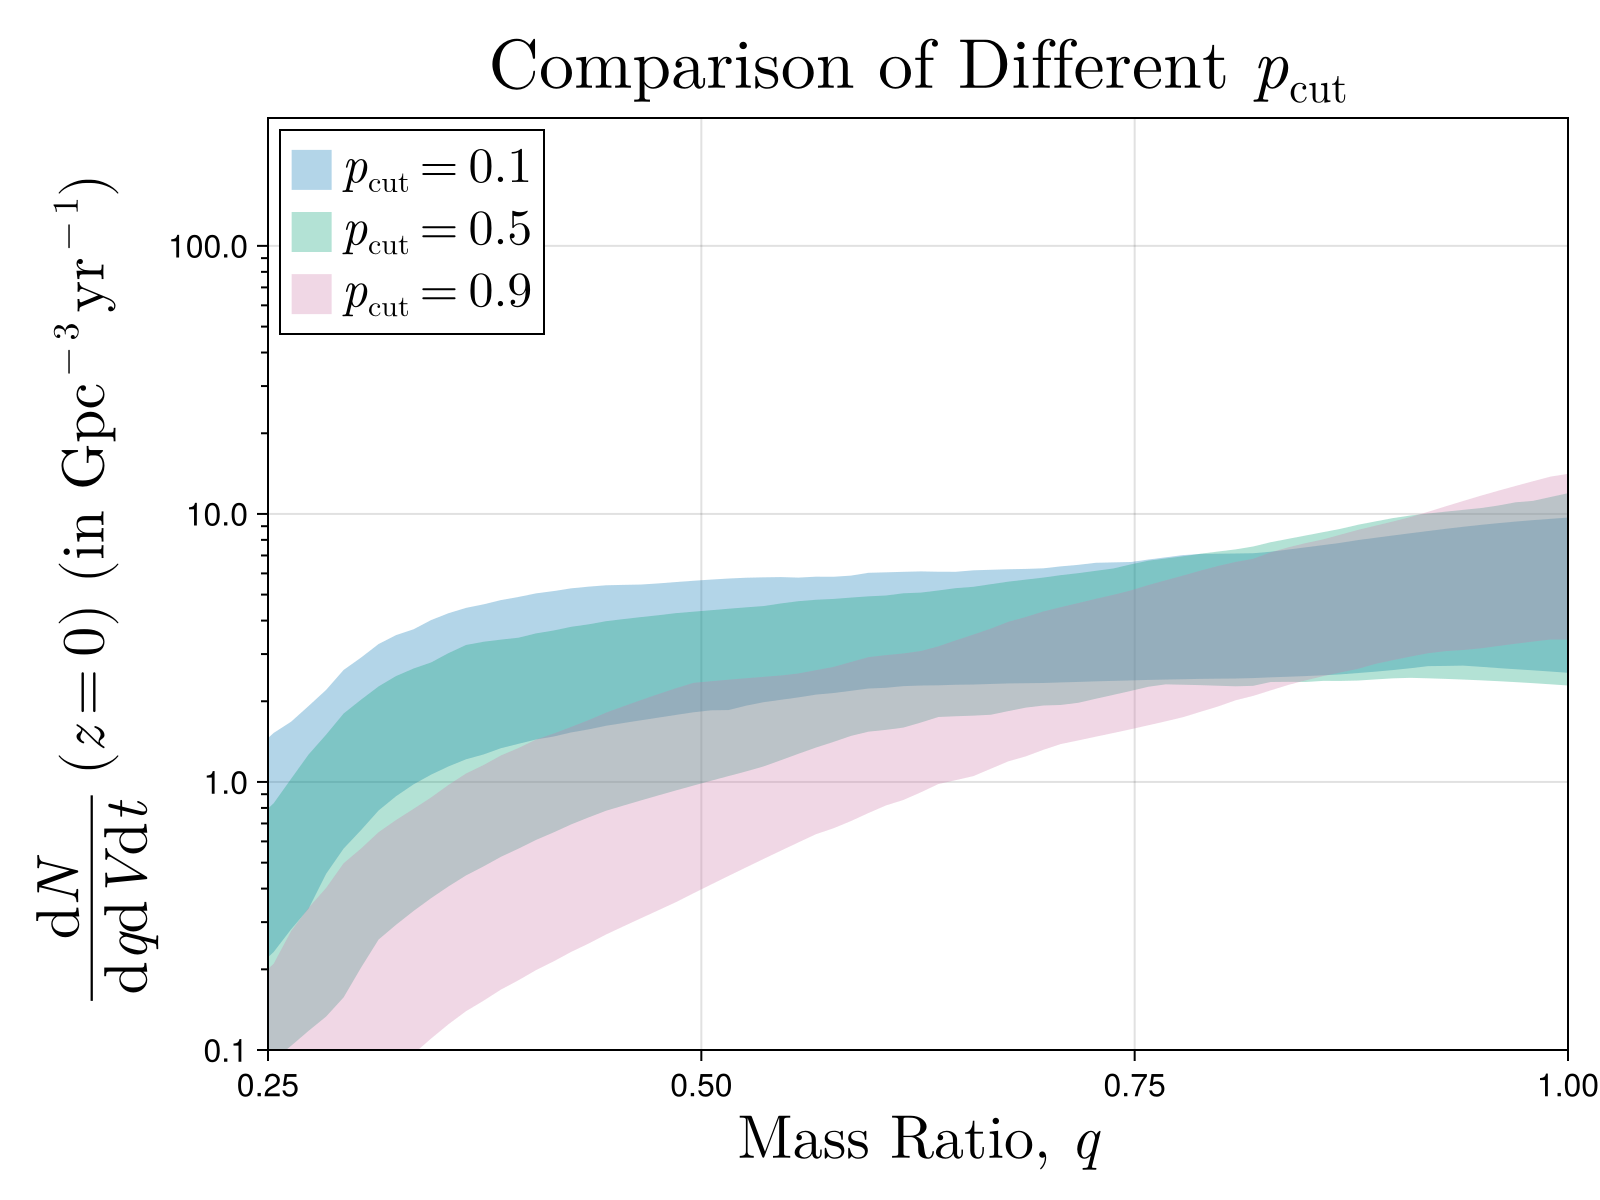

In [27]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max)) 
qs=collect(range(0.001, stop=1.0, length=100)) 
draws=100
rng=Random.default_rng()
limits=(0.25, 1, 0.1, 300)
yticks=[0.1, 1, 10, 100]
yminorticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]
colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green


f = Figure(size=(800, 600))
    
a = Axis(f[1,1],
    xlabel = L"\mathrm{Mass~Ratio},~q",
    ylabel = L"\frac{\mathrm{d} N}{\mathrm{d} q \mathrm{d} V \mathrm{d} t}~(z=0)~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    yscale = log10,
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    ytickformat = "{:.1f}",
    xlabelsize = xlabelsize,
    ylabelsize = ylabelsize,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    titlesize = titlesize,
    title=L"\mathrm{Comparison~of~Different}~p_{\mathrm{cut}}",
    limits = limits
)

# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")
axislegend(a, position = :lt, labelsize = 25, framevisible = true)  # top-right inside the plot
if plot_save
    save(outdir * "appen_pcut_q_marginal.pdf", f, px_per_unit=3)
end
f